In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import uproot
import astropy.io.fits as fits

from tqdm import tqdm

In [2]:
# ubicación de los archivos de entrada y salida
root_folder = r'./datos_root/'
fits_folder = './datos_fits/'
png_folder = './datos_png/'
filename = 'catalog_data_3813_to_3872.root'
orden_ccds = np.array([1, 2, 7, 8, 11, 13, 3, 5, 9, 12, 14, 4, 6, 10])

# lee el archivo root
file = uproot.open(root_folder+filename)
file.keys()

['config;1', 'hitSumm;1']

In [3]:
# número de filas o instancias
print(f'{file["hitSumm;1"].num_entries} entries')
print()

# información sobre los atributos o columnas
file['hitSumm;1'].show()

5758476 entries

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runID                | int32_t                  | AsDtype('>i4')
ohdu                 | int32_t                  | AsDtype('>i4')
expoStart            | int32_t                  | AsDtype('>i4')
nSat                 | int32_t                  | AsDtype('>i4')
flag                 | int32_t                  | AsDtype('>i4')
xMin                 | int32_t                  | AsDtype('>i4')
xMax                 | int32_t                  | AsDtype('>i4')
yMin                 | int32_t                  | AsDtype('>i4')
yMax                 | int32_t                  | AsDtype('>i4')
E0                   | float                    | AsDtype('>f4')
n0                   | float                    | AsDtype('>f4')
xBary0               | float                    | AsDtype('>f4')
yBary0               | float             

In [4]:
# Determina el tamaño de la imagen
xMax = np.max(file['hitSumm;1']['xMax'].array(library="np"))
yMax = np.max(file['hitSumm;1']['yMax'].array(library="np"))
shape = (yMax+1, xMax+1)
shape

(4220, 4262)

In [5]:
# headers de tipo entero
headers = file['hitSumm;1'].arrays(['runID', 'ohdu', 'expoStart', 'nSat', 'flag'], library="np")

# imprime el número de valores únicos
for key in headers:
    print(f'\'{key}\': len(unique) = {len(np.unique(headers[key]))}')

# imprime las instancias de estos valores
print()
print(f'\'ohdu\': unique = {np.unique(headers["ohdu"])}')
print(f'\'flag\': unique = {np.unique(headers["flag"])}')

'runID': len(unique) = 60
'ohdu': len(unique) = 13
'expoStart': len(unique) = 60
'nSat': len(unique) = 326
'flag': len(unique) = 22

'ohdu': unique = [ 2  3  4  5  6  7  8  9 10 11 13 14 15]
'flag': unique = [-128 -126 -124 -122 -116 -114 -112 -110 -108 -106 -100  -98    0    2
    4    6   12   16   18   20   22   28]


In [6]:
# Calcula los intervalos de cada una de las corridas
#assert np.all(headers["runID"][:-1] <= headers["runID"][1:]), 'La columna runID debe estar ordenada.'
runID, stop = np.unique(headers['runID'], return_index=True)
stop = np.append(stop, [len(headers['runID'])])
runID, stop

(array([3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823,
        3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834,
        3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845,
        3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856,
        3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867,
        3868, 3869, 3870, 3871, 3872], dtype=int32),
 array([      0,   93873,  188321,  283454,  378312,  471456,  566586,
         661576,  756046,  851154,  947072, 1043488, 1137877, 1232715,
        1329116, 1425375, 1520933, 1616975, 1712304, 1809824, 1907591,
        2003833, 2101787, 2196825, 2294093, 2391098, 2488593, 2585767,
        2683813, 2781978, 2879516, 2978841, 3075862, 3172999, 3270708,
        3368417, 3466248, 3560800, 3655759, 3749708, 3844541, 3940033,
        4034506, 4129436, 4224954, 4321061, 4415242, 4510468, 4604665,
        4700433, 4796883, 4893637, 4989538, 5085251, 5180339, 5275680,
        5

In [7]:
# selecciona las instancias de la primera corrida
first_run = file['hitSumm;1'].arrays(entry_start=stop[0], entry_stop=stop[1], library="np")
len(first_run['runID'])

93873

In [8]:
# función para exportar un listado de matrices como imagen fits
def mats_to_fits(img, name):
    hdul = fits.HDUList()

    for mat in img:
        hdu = fits.ImageHDU(mat)
        hdul.append(hdu)

    hdul.writeto(fits_folder+name+'.fits', overwrite=True)

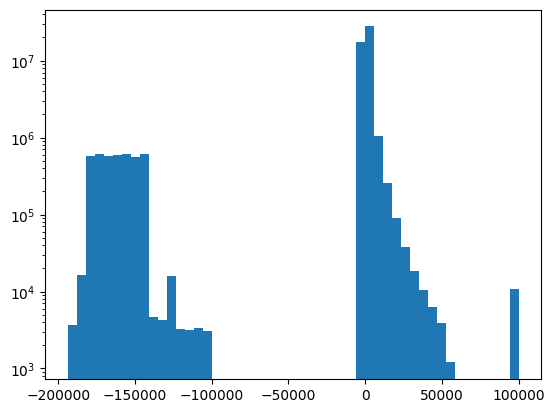

In [9]:
# genera un histograma de los valores de energía
energy_values = np.concatenate(list(first_run['ePix'])).ravel()

#energy_values = energy_values[energy_values != 1e10]
energy_values = energy_values.copy()
energy_values[energy_values == 1e10] = 1e5

#energy_values = energy_values[energy_values < -350]

plt.hist(energy_values, log=True, bins=50)
plt.show()

### Generar imágenes FITS y catálogo

In [10]:
# matrices donde irán las imágenes de cada CCD
imgs = np.zeros((14, *shape))

# lista de entradas del dataframe
data = {'muonCCD':[], 'centerX':[], 'centerY':[], 'meanX':[], 'meanY':[], 'sizeX':[], 'sizeY':[], 'asymX':[], 'asymY':[]}

# itera a través de cada evento
for i in tqdm(range(len(first_run['runID']))):
    
    x = first_run['xPix'][i]
    y = first_run['yPix'][i]
    e = first_run['ePix'][i].copy()
    
    # elimina los valores negativos y saturados
    e[e < 0] = 0
    e[e == 1e10] = 1e5
    
    # calcula las métricas de cada impacto
    data['muonCCD'].append(int(first_run['ohdu'][i]) - 1)
    data['centerX'].append((np.max(x) + np.min(x))/2)
    data['centerY'].append((np.max(y) + np.min(y))/2)
    data['meanX'].append(np.sum(x*e)/(np.sum(e)))
    data['meanY'].append(np.sum(y*e)/(np.sum(e)))
    data['sizeX'].append(np.max(x) - np.min(x))
    data['sizeY'].append(np.max(y) - np.min(y))
    data['asymX'].append(np.sum(x*e)/(np.sum(e)) - (np.max(x) + np.min(x))/2)
    data['asymY'].append(np.sum(y*e)/(np.sum(e)) - (np.max(y) + np.min(y))/2)

    # selecciona la matriz correspondiente al CCD
    mat = imgs[int(first_run['ohdu'][i]) - 2]

    # almacena los valores de energía
    mat[y, x] = e
    #mat[y, x] += 1

# ordena los CCDs
imgs = imgs[orden_ccds-1]

# cambia la escala
#mat = np.sqrt(mat, out=np.zeros_like(mat), where=(mat!=0))

100%|███████████████████████████████████| 93873/93873 [00:13<00:00, 6753.32it/s]


In [13]:
# guarda las imagenes como archivos fits
mats_to_fits(imgs[:,:2000,:2000], 'connie_img')

In [14]:
df = pd.DataFrame(data)
df.insert(0, 'eventNumber', 0)
df

,eventNumber,muonCCD,centerX,centerY,meanX,meanY,sizeX,sizeY,asymX,asymY
0,0,1,1321.5,30.5,1322.239112,28.383221,13,61,0.739112,-2.116779
1,0,1,2692.0,12.0,2691.810627,11.799197,12,24,-0.189373,-0.200803
2,0,1,2837.5,50.0,2840.310109,44.198508,23,56,2.810109,-5.801492
3,0,1,1068.0,39.5,1067.839702,39.479412,10,9,-0.160298,-0.020588
4,0,1,889.0,49.0,889.234531,48.978512,8,8,0.234531,-0.021488
...,...,...,...,...,...,...,...,...,...,...
93868,0,14,1175.0,4217.5,1174.344279,4218.493344,6,3,-0.655721,0.993344
93869,0,14,1464.0,4217.5,1464.342775,4217.963022,6,3,0.342775,0.463022
93870,0,14,1834.0,4217.5,1834.101142,4218.527045,6,3,0.101142,1.027045
93871,0,14,1874.5,4217.5,1874.033257,4218.747490,9,3,-0.466743,1.247490


### Asociar manualmente impactos a tracks

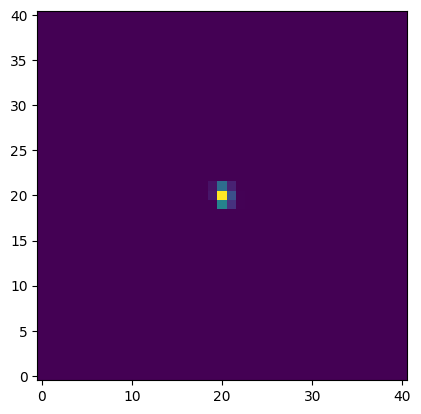

In [15]:
def view_region(imgs, x, y, r, ccd=None):
    if len(imgs.shape) == 3:
        plt.imshow(imgs[ccd-1][y-r:y+r+1, x-r:x+r+1], origin='lower')
    else:
        plt.imshow(imgs[y-r:y+r, x-r:x+r], origin='lower')

view_region(imgs, ccd=1, x=1322, y=1604, r=20)

In [20]:
def find_nearest(first_run, ccd, x, y):
    
    ccd = orden_ccds[ccd-1]
    
    for i in range(len(first_run['runID'])):
        
        if first_run['ohdu'][i]-1 != ccd:
            continue
    
        if x in first_run['xPix'][i] and y in first_run['yPix'][i]:
            print(i)

def view_event(first_run, i, r=20):
    img = np.zeros(shape)

    x = first_run['xPix'][i]
    y = first_run['yPix'][i]
    e = first_run['ePix'][i].copy()

    # elimina los valores negativos y saturados
    e[e < 0] = 0
    e[e == 1e10] = 1e5

    # almacena los valores de energía
    img[y, x] = e

    # muestra el impacto
    df = pd.DataFrame({
        'muonCCD': int(first_run['ohdu'][i]) - 1,
        'centerX': (np.max(x) + np.min(x))/2, 'centerY': (np.max(y) + np.min(y))/2,
        'meanX': np.sum(x*e)/(np.sum(e)),     'meanY': np.sum(y*e)/(np.sum(e)),
        'sizeX': np.max(x) - np.min(x),       'sizeY': np.max(y) - np.min(y),
        'asymX': np.sum(x*e)/(np.sum(e)) - (np.max(x) + np.min(x))/2,
        'asymY': np.sum(y*e)/(np.sum(e)) - (np.max(y) + np.min(y))/2,
    }, index=[0])
    view_region(img, x=int(df['meanX'][0]), y=int(df['meanY'][0]), r=r)
    return df

1449


In [41]:
df.head(1)

,eventNumber,muonCCD,centerX,centerY,meanX,meanY,sizeX,sizeY,asymX,asymY
0,0,1,1321.5,30.5,1322.239112,28.383221,13,61,0.739112,-2.116779


,muonCCD,centerX,centerY,meanX,meanY,sizeX,sizeY,asymX,asymY
0,1,1322.5,1604.0,1322.167398,1603.959099,9,10,-0.332602,-0.040901


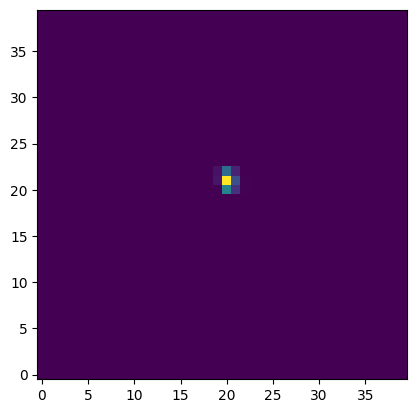

In [47]:


view_event(first_run, 1449, r=20)

In [32]:
track = [770, 4911]

4911


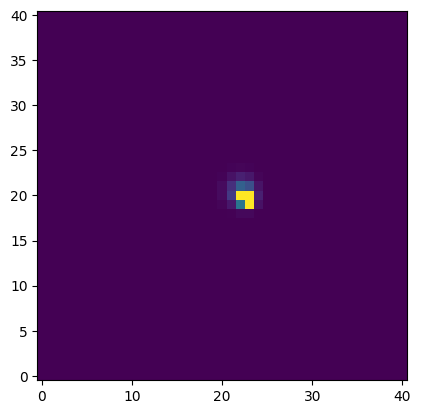

In [22]:
ccd = 2
x = 480
y = 884

view_region(imgs, ccd=ccd, x=x, y=y, r=20)
find_nearest(first_run, ccd=ccd, x=x, y=y)

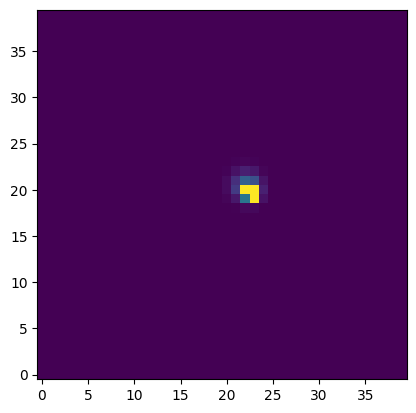

In [31]:
view_event(first_run, 4911, x_=x, y_=y, r_=20)